# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$? What if we change the support of $M$?

In [1]:
# Import everything needed
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import HMProcess, plot_hm_process
from kalman import SteadyStateKalmanFilter
from rnn import NeuralNet
from utils import calc_loss, mk_rand_matrix, mk_rand_matrix_envals

In [2]:
# Define some arbitrary parameters
rng = np.random.default_rng()

def create_process(rng, A=None):
    if A is None:
        A = np.diag([0.98, 0.96, 0.85])
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 25
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

proc = create_process(rng)

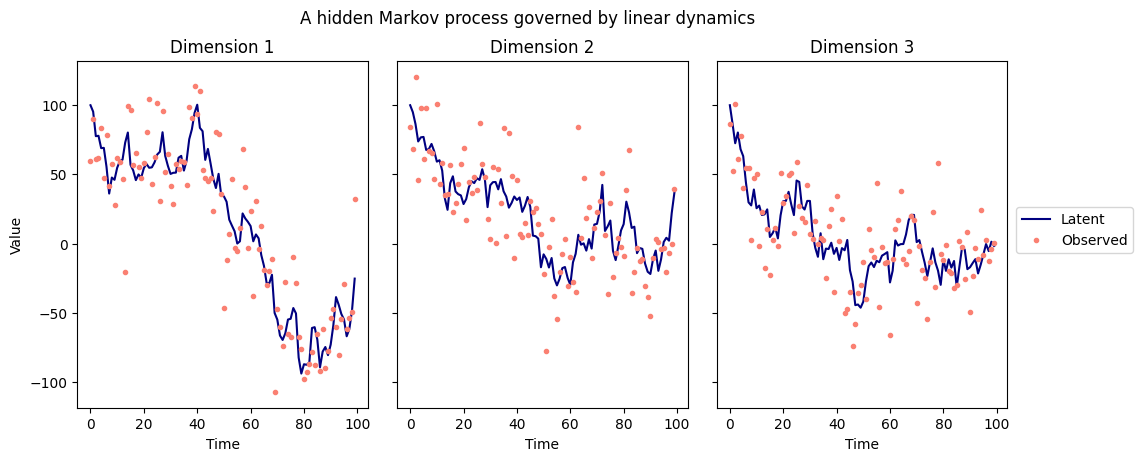

In [3]:
ts, xs, ys = proc.simulate()
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

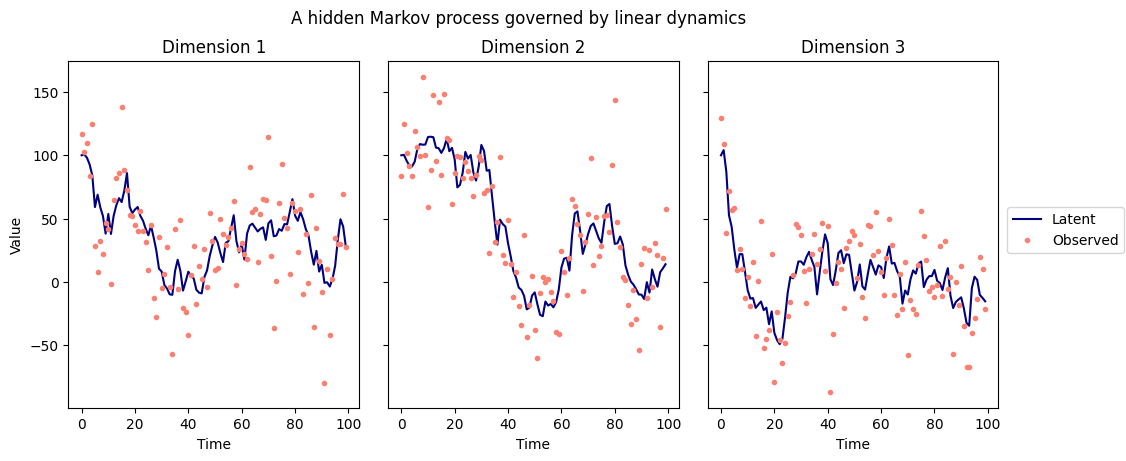

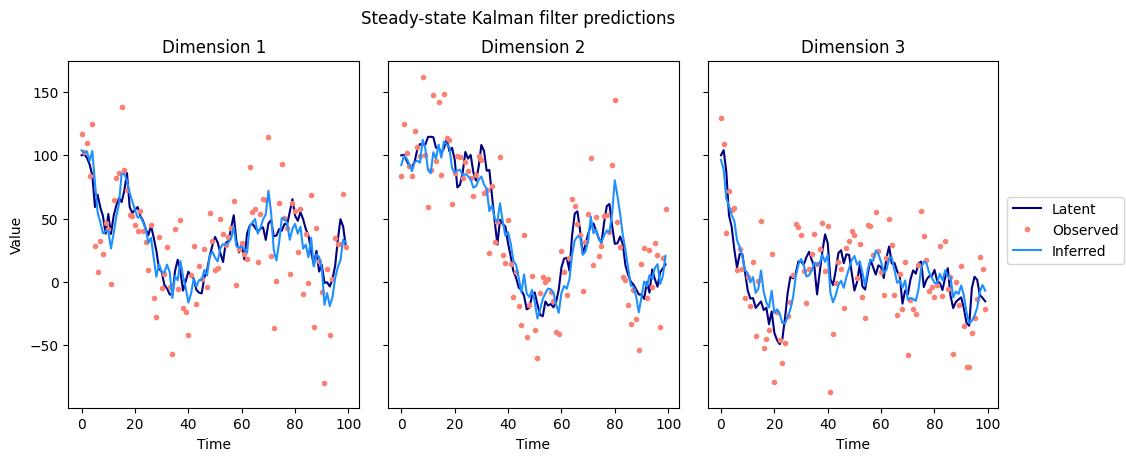

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = proc.simulate()
kf = SteadyStateKalmanFilter(proc)
xhats = kf.infer(ys)

# Now, let's plot it!
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

In [5]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
# First, let's make the matrix A of the hidden Markov process random.
A = mk_rand_matrix_envals(rng)
proc = create_process(rng, A)
kf = SteadyStateKalmanFilter(proc)

In [6]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    for _ in range(5):
        M = mk_rand_matrix_envals(rng, envals=np.array([0.63, 0.63, 0.66]))
        for i in tqdm.tqdm(range(5)):
            c = i/5
            M2 = (1-c)*M + c*kf.M_infty
            nn = NeuralNet(kf.K_infty, M2, np.eye(3), proc.x0)
            Ls = nn.batch_test(100, proc)
            distances.append(calc_loss(M2, kf.M_infty))
            losses.append(np.mean(Ls))
    return distances, losses

distances, losses = test_M_landscape()

100%|█████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


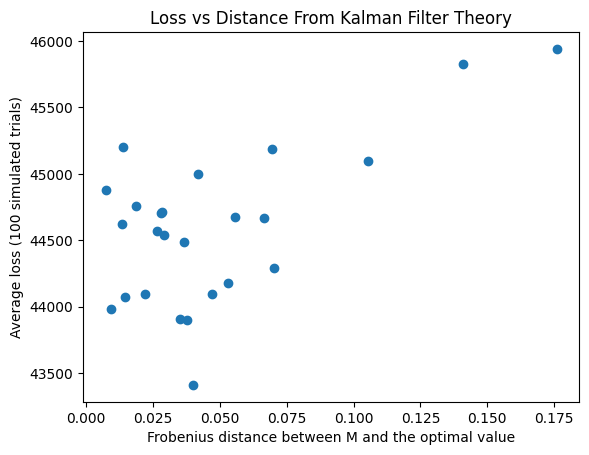

In [7]:
# Let's try plotting our results
plt.scatter(np.sqrt(2*np.array(distances)), losses)
plt.xlabel('Frobenius distance between M and the optimal value')
plt.ylabel('Average loss (100 simulated trials)')
plt.title('Loss vs Distance From Kalman Filter Theory')
plt.show()

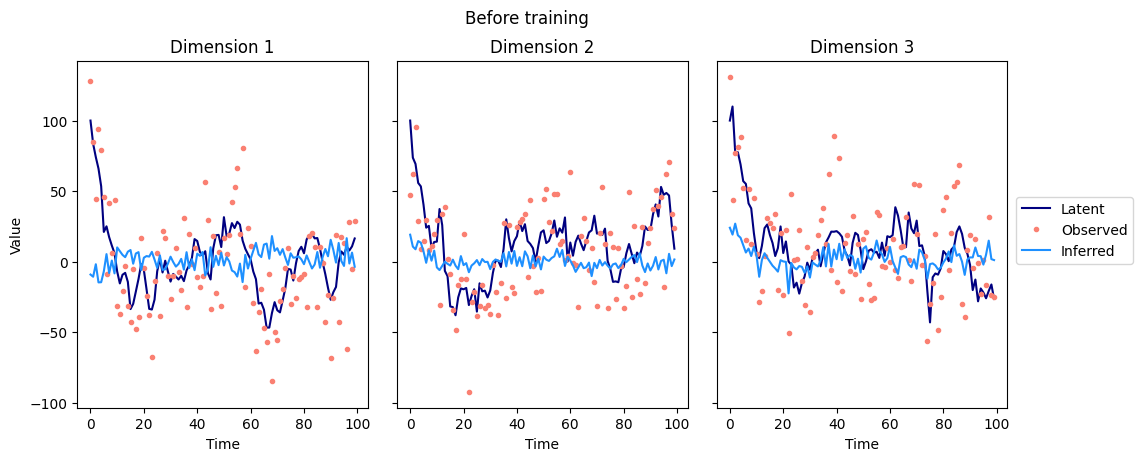

Loss 104349.53288353504
M = [[-0.00116222 -0.01635977  0.19544215]
 [ 0.02526588 -0.01849343 -0.0494424 ]
 [-0.05726876  0.01743461 -0.01508164]]
K = [[-0.20866718  0.05953216 -0.02326669]
 [ 0.11167833 -0.00181861  0.07018963]
 [ 0.04129853  0.1527908   0.13053401]]


100%|███████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.19it/s]


Mean loss 128407.36257857861


100%|███████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.43it/s]


Mean loss 102165.37234551823


100%|███████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.33it/s]


Mean loss 80544.64319678306


100%|███████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.32it/s]


Mean loss 72519.93749844244


100%|███████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.36it/s]


Mean loss 60343.490732302496


100%|███████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.36it/s]


Mean loss 55042.319128328774


100%|███████████████████████████████████████████████████████| 40/40 [00:36<00:00,  1.10it/s]


Mean loss 46779.847595909945


100%|███████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.35it/s]


Mean loss 50633.6918018562


100%|███████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.19it/s]


Mean loss 45888.25492936124


100%|███████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.35it/s]


Mean loss 45004.00732197995


100%|███████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


Mean loss 43696.89437190678


100%|███████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


Mean loss 43633.74478886889


100%|███████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


Mean loss 41446.60196764801


100%|███████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.28it/s]


Mean loss 40869.89513898709


100%|███████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


Mean loss 38701.90712079677


100%|███████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


Mean loss 40513.92886578894


100%|███████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.25it/s]


Mean loss 39097.120565142286


100%|███████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.36it/s]


Mean loss 37308.40414907209


100%|███████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.41it/s]


Mean loss 38622.07212275868


100%|███████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


Mean loss 37423.6388807872


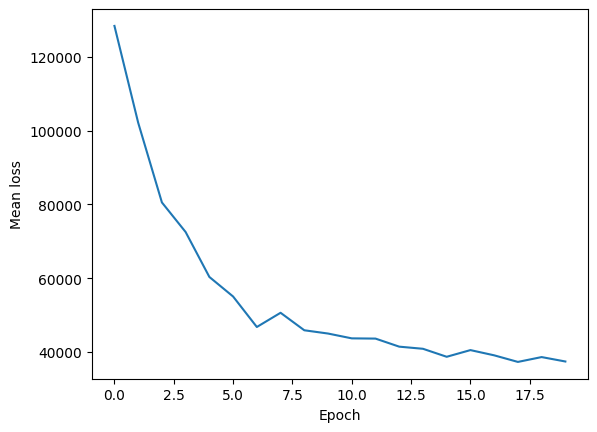

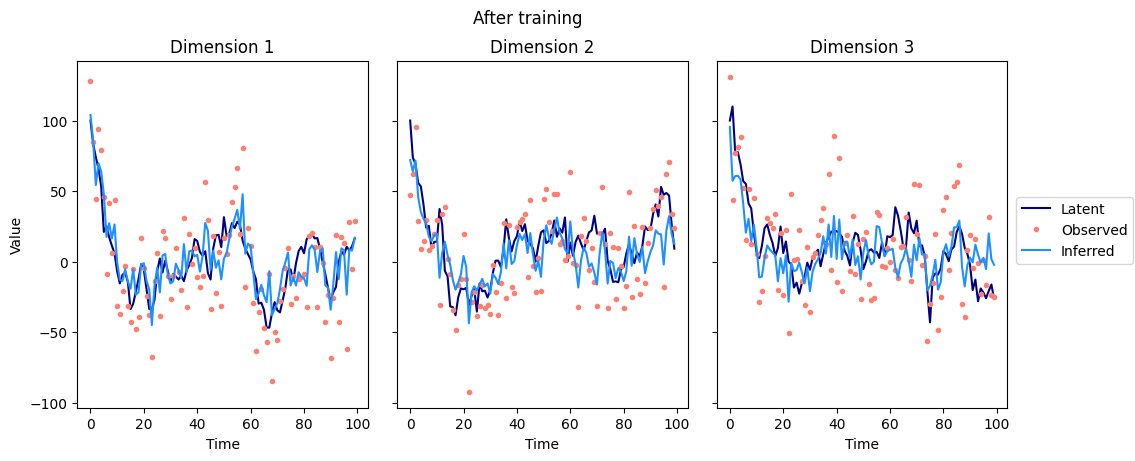

Loss 39481.830909084965
M = [[0.1899229  0.06018011 0.2466081 ]
 [0.10678723 0.177079   0.0972444 ]
 [0.03605981 0.1268239  0.18481794]]
K = [[ 0.44135405  0.02478139 -0.02481835]
 [ 0.03112093  0.39372229  0.0876821 ]
 [ 0.0704257   0.07680873  0.36768204]]


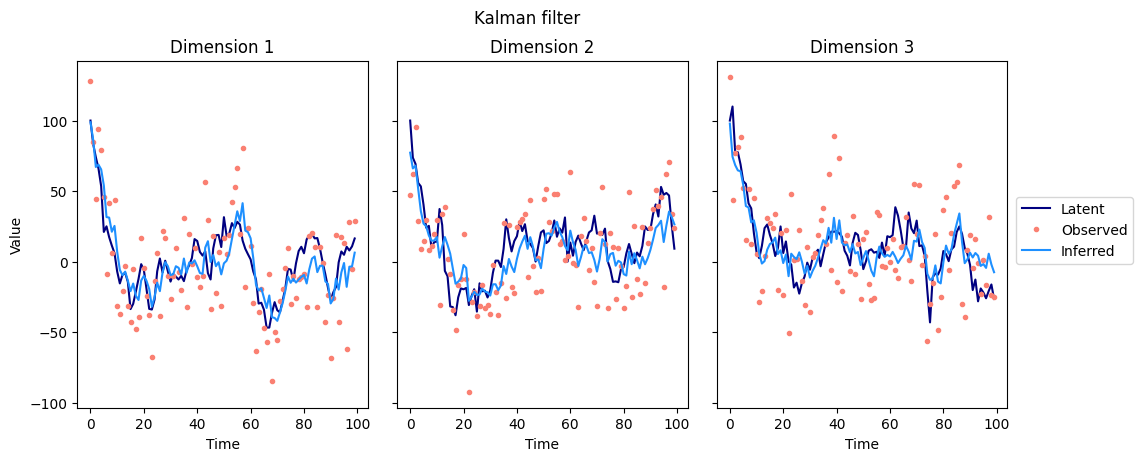

Loss 29740.52603612848
M = [[ 0.65066145  0.01089764 -0.02365027]
 [-0.00989682  0.64098383  0.00707889]
 [ 0.01034575  0.00609756  0.63119285]]
K = [[ 0.28122283 -0.00067709 -0.0065839 ]
 [-0.00067709  0.26744997  0.00717148]
 [-0.0065839   0.00717148  0.25664971]]


In [9]:
# What happens when we train the neural net on this task?
def compare_nn_kalman():
    nn = NeuralNet(0.1*mk_rand_matrix(rng), 0.1*mk_rand_matrix(rng), np.eye(3), proc.x0)
    ts, xs, ys = proc.simulate()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    losses = nn.train(np.array([1e-6]*10), 40, proc)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Mean loss')
    plt.show()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    # How does it compare to a Kalman filter?
    xhats = kf.infer(ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', kf.M_infty)
    print('K =', kf.K_infty)

#compare_nn_kalman()

[[0 0 1]
 [1 1 0]
 [0 1 1]]


100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


Mean loss 142863.98475107088


100%|███████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


Mean loss 107616.20268784973


100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


Mean loss 88398.40357709702


100%|███████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


Mean loss 71632.47424691709


100%|███████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.33it/s]


Mean loss 65542.63449187632


100%|███████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]


Mean loss 66390.91467508291


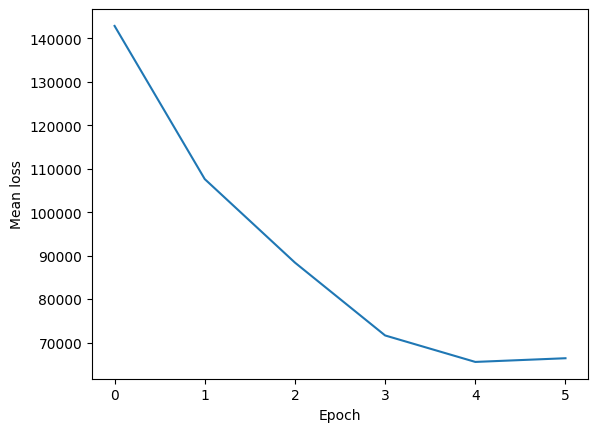

[[1 1 0]
 [1 1 1]
 [0 0 0]]


100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


Mean loss 100396.03005365496


100%|███████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


Mean loss 83558.39124237832


100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


Mean loss 66481.22319536659


100%|███████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.25it/s]


Mean loss 58948.02816682103


100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


Mean loss 55374.20460079757


100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


Mean loss 52474.269328948576


100%|███████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.48it/s]


Mean loss 52165.53562798365


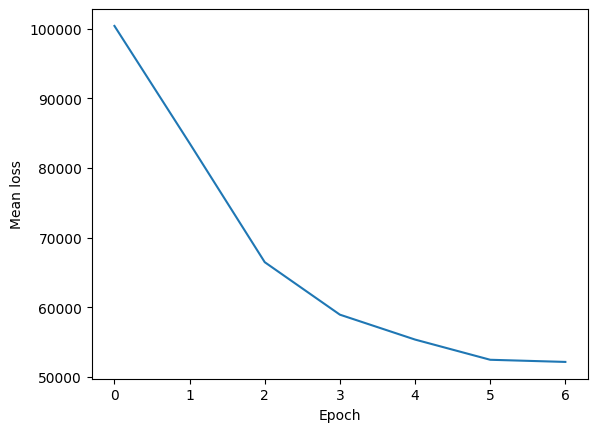

In [11]:
def mk_rand_mask(num_neurons=3):
    return np.random.randint(0,2,size=(num_neurons,num_neurons))

def test_masks():
    for _ in range(2):
        mask = mk_rand_mask()
        print(mask)
        nn = NeuralNet(0.1*mk_rand_matrix(rng), 0.1*mk_rand_matrix(rng), np.eye(3), proc.x0, mask=mask)
        num_epochs, losses = nn.train_until_converge(1e-6, 1000, 20, proc)
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Mean loss')
        plt.show()

test_masks()

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity.

In [23]:
# Let's start with 1 dimension for easy visualization
def create_1d_process(rng, A):
    x0 = np.array([100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.array([[1]])
    sigma_obs = 50
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 4
num_ticks = 20
amk_range = 0.9
num_trials_per = 40
W = np.array([[1]])

In [25]:
def find_nn_values_A_M_K(num_nns=2):
    mks = np.zeros((num_a_ticks,num_nns,2))

    for i, a_ in enumerate(np.linspace(-1*amk_range,amk_range,num_a_ticks)):
        A = np.array([[a_]])
        for j in tqdm.tqdm(range(num_nns)):
            proc = create_1d_process(rng, A)
            nn = NeuralNet(0.1*mk_rand_matrix(rng, n=1), 0.1*mk_rand_matrix(rng, n=1), np.eye(1), proc.x0)
            nn.train_until_converge(5e-7, 1000, num_trials_per, proc,
                                    print_loss=False, progress_bar=False)
            mks[i,j,0] = nn.M[0,0]
            mks[i,j,1] = nn.K[0,0]

    return mks


mks = find_nn_values_A_M_K()

100%|████████████████████████████████████████████████████████| 2/2 [06:54<00:00, 207.16s/it]


In [26]:
def test_A_M_K_loss_landscape():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    
    for i1, a_ in tqdm.tqdm(enumerate(np.linspace(-1*amk_range,amk_range,num_a_ticks)), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*amk_range,amk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*amk_range,amk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                proc = create_1d_process(rng, A)
                nn = NeuralNet(M, K, W, proc.x0)
                Ls = nn.batch_test(batch_size, proc)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

losses = test_A_M_K_loss_landscape()

100%|████████████████████████████████████████████████████████| 4/4 [14:13<00:00, 213.31s/it]


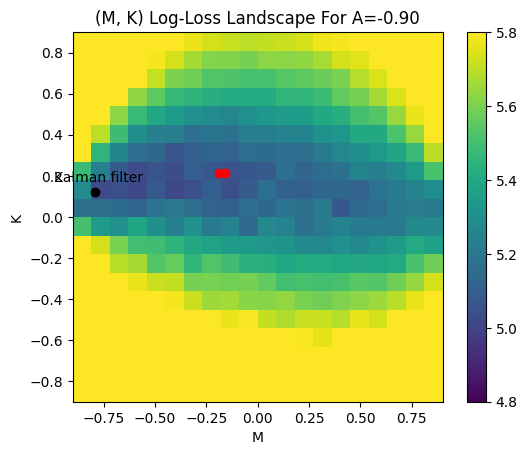

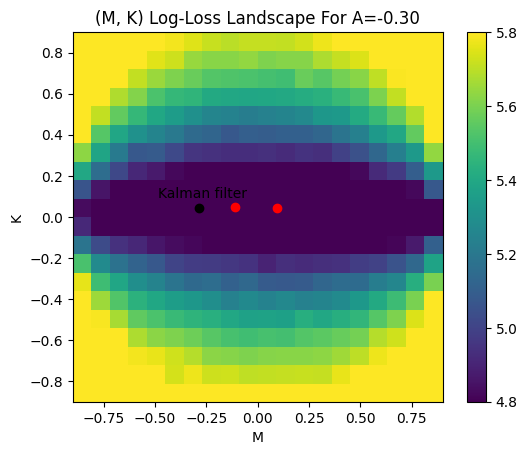

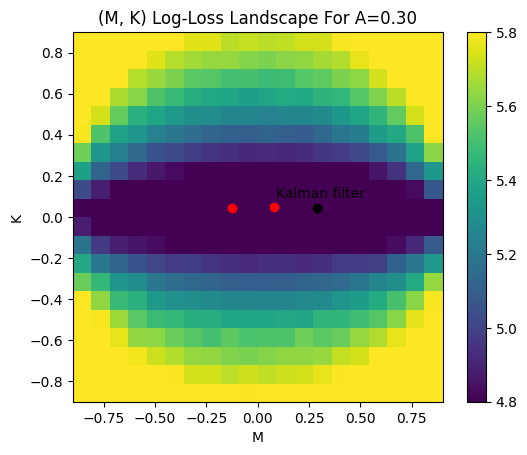

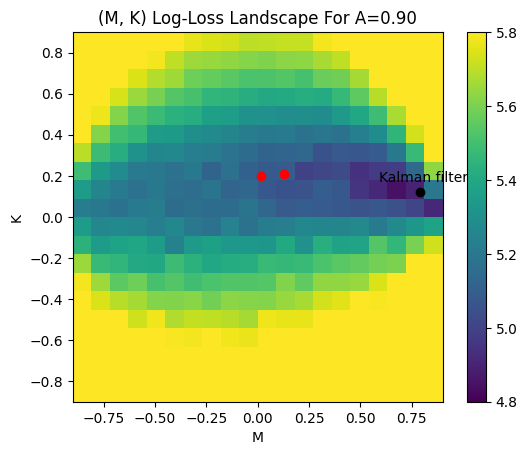

In [28]:
norm = matplotlib.colors.Normalize(4.8, 5.8)
for i1, a_ in enumerate(np.linspace(-1*amk_range,amk_range,num_a_ticks)):

    # Loss landscape
    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*amk_range,amk_range,-1*amk_range,amk_range), norm=norm)
    plt.xlabel('M')
    plt.ylabel('K')

    # Where does the Kalman filter fall?
    A = np.array([[a_]])
    proc = create_1d_process(rng, A)
    kf = SteadyStateKalmanFilter(proc)
    plt.plot(kf.M_infty, kf.K_infty, color='black', marker='o')
    plt.annotate('Kalman filter', (kf.M_infty, kf.K_infty),
                 xytext=(kf.M_infty-0.2, kf.K_infty+0.05), color='black')

    # What about the RNNs?
    plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')
    
    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
    plt.xlim(-1*amk_range, amk_range)
    plt.ylim(-1*amk_range, amk_range)
    plt.colorbar(c)
    plt.show()

117777.79372496987
113548.14631720494


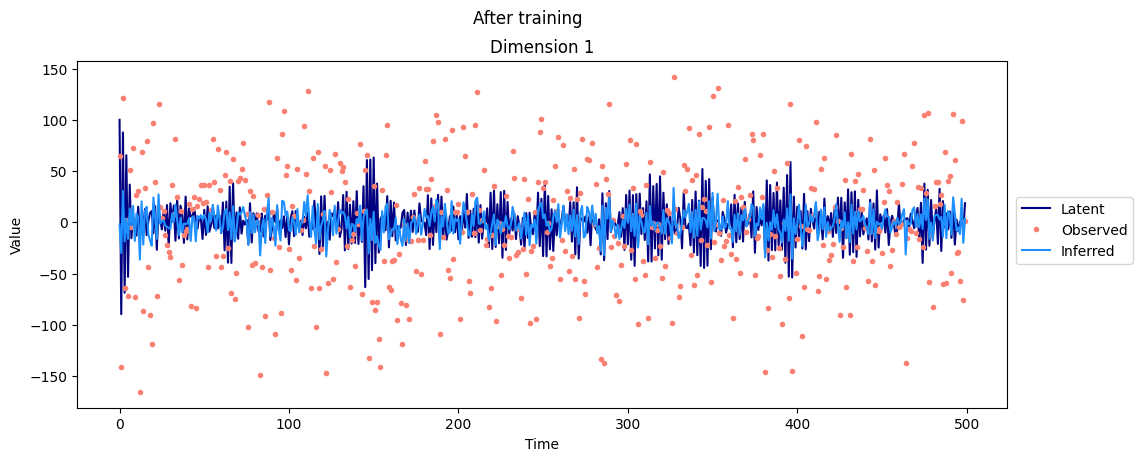

Loss 106742.34552013848
M = [[-0.15773625]]
K = [[0.21420419]]


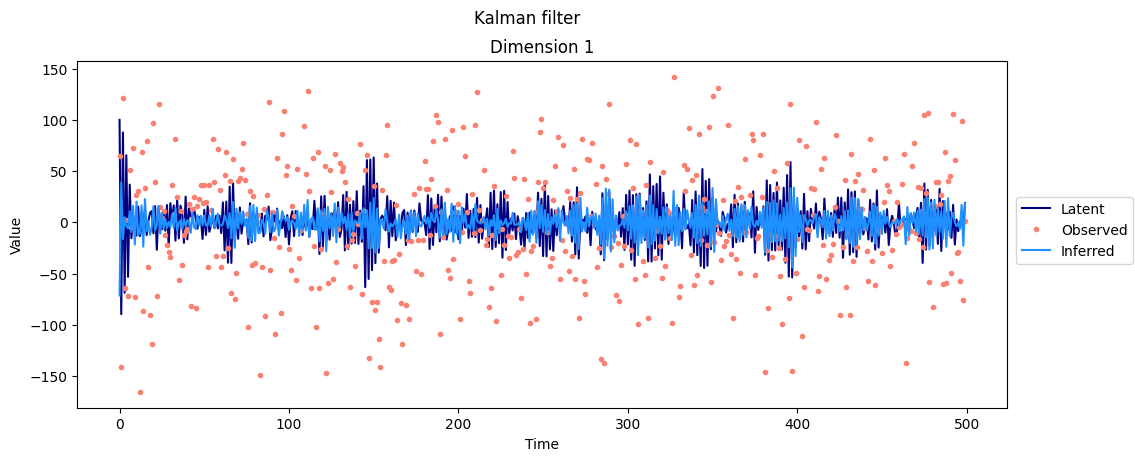

Loss 103758.515369924
M = [[-0.79044434]]
K = [[0.12172851]]


In [29]:
def test_mk(proc, m_, k_):
    A, M, K = proc.A, np.array([[m_]]), np.array([[k_]])
    nn = NeuralNet(M, K, W, proc.x0)
    proc = create_1d_process(rng, A)
    losses = nn.batch_test(100, proc)
    print(np.mean(losses))

A = np.array([[-0.90]])
proc = create_1d_process(rng, A)
kf = SteadyStateKalmanFilter(proc)

test_mk(proc, mks[0,0,0], mks[0,0,1])
test_mk(proc, kf.M_infty, kf.K_infty)

ts, xs, ys = proc.simulate()

nn = NeuralNet(np.array([[mks[0,0,0]]]), np.array([[mks[0,0,1]]]), np.eye(1), proc.x0)
_, xhats = nn.forward(ys)
plot_hm_process('After training', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs))
print('M =', nn.M)
print('K =', nn.K)

xhats = kf.infer(ys)
plot_hm_process('Kalman filter', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs))
print('M =', kf.M_infty)
print('K =', kf.K_infty)